In [45]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Add, Layer, Reshape, Multiply
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [ ]:
#check if tensorflow is built with cuda
import tensorflow as tf
from tensorflow.python.client import device_lib

print(f'Built with cuda: {tf.test.is_built_with_cuda()}' )
print(f'Tensorflow version: {tf.__version__}')
print(device_lib.list_local_devices())

In [2]:
#enable memory growth for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-03-28 09:57:30.651208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 09:57:30.811000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 09:57:30.811055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [35]:
def plot_confusion_matrix(y_true, y_pred_probs, labels):
    
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    #plotting
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xticks(rotation=45)
    ax.invert_xaxis()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [4]:
dataset_train_base = "/mnt/c/Users/olson/OneDrive - Kennesaw State University/Desktop/School/Machine Learning/Facial Expression Recognition/train"
dataset_validation_base = "/mnt/c/Users/olson/OneDrive - Kennesaw State University/Desktop/School/Machine Learning/Facial Expression Recognition/validation"

In [57]:
class_list = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_count = len(class_list)
image_size = (48, 48)
batch_size = 384

In [58]:
#using int label for sparse categorical crossentropy
#dataset is grayscale, so we will have one channel in the CNN

train_dataset = image_dataset_from_directory(
    dataset_train_base,
    labels='inferred',
    label_mode='categorical',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

validation_dataset = image_dataset_from_directory(
    dataset_validation_base,
    labels='inferred',
    label_mode='categorical',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

Found 28385 files belonging to 6 classes.
Found 6955 files belonging to 6 classes.


In [59]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
#number of data points for each class
train_class_counts = {}
validation_class_counts = {}

dataset_class_list = train_dataset.class_names

for images, labels in train_dataset:
    for label in labels:
        train_class_counts[dataset_class_list[np.argmax(label)]] = train_class_counts.get(dataset_class_list[np.argmax(label)], 0) + 1

for images, labels in validation_dataset:
    for label in labels:
        validation_class_counts[dataset_class_list[np.argmax(label)]] = validation_class_counts.get(dataset_class_list[np.argmax(label)], 0) + 1

print(f'Train class counts: {train_class_counts}')
print(f'Validation class counts: {validation_class_counts}')

2024-03-28 09:58:57.806438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train class counts: {'fear': 4103, 'neutral': 4982, 'angry': 3993, 'happy': 7164, 'sad': 4938, 'surprise': 3205, 'disgust': 436}
Validation class counts: {'fear': 1018, 'surprise': 797, 'neutral': 1216, 'angry': 960, 'happy': 1825, 'sad': 1139, 'disgust': 111}


2024-03-28 09:59:05.022100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

input_layer = Input(shape=(image_size[0], image_size[1], 1))

conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_1 = squeeze_excite_block(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_1)
conv_2 = squeeze_excite_block(conv_2)

pool = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool)
conv_3 = squeeze_excite_block(conv_3)

conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3)
conv_4 = squeeze_excite_block(conv_4)

pool = MaxPooling2D((2, 2))(conv_4)

conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool)
conv_5 = squeeze_excite_block(conv_5)

conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_5)
conv_6 = squeeze_excite_block(conv_6)

pool = MaxPooling2D((2, 2))(conv_6)

pool = GlobalAveragePooling2D()(pool)

dense_1 = Dense(256, activation='relu')(pool)
dense_1 = Dropout(0.5)(dense_1)

output_layer = Dense(class_count, activation='softmax')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 48, 48,    │        640 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_36[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1, 1, 4)   │        256 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1, 1, 64)  │        256 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 48, 48,    │          0 │ conv2d_36[0][0],  │
│ (Multiply)          │ 64)               │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 48, 48,    │     36,928 │ multiply_6[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_37[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1, 1, 4)   │        256 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1, 1, 64)  │        256 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 48, 48,    │          0 │ conv2d_37[0][0],  │
│ (Multiply)          │ 64)               │            │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24,    │          0 │ multiply_7[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 24, 24,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_38[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1, 1, 8)   │      1,024 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 1, 128) │      1,024 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 24, 24,    │          0 │ conv2d_38[0][0],

 Total params: 1,233,094 (4.70 MB)

 Trainable params: 1,233,094 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/150


I0000 00:00:1711640263.863082   49693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1711640264.285143   49695 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1711640264.351146   49693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1711640264.921834   49696 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 80 bytes spill stores, 184 bytes spill loads

I0000 00:00:1711640266.014821   49693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2183', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1711640266.266246   4

73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2478 - loss: 1.7641

I0000 00:00:1711640294.741181   50185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1711640295.303407   50179 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1553', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1711640296.008348   50183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2185', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1711640296.839792   50184 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2185', 60 bytes spill stores, 32 bytes spill loads

I0000 00:00:1711640296.901087   50178 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2183', 100 bytes spill stores, 108 bytes spill loads

I0000 00:00:1711640297.152091   

74/74 ━━━━━━━━━━━━━━━━━━━━ 64s 516ms/step - accuracy: 0.2478 - loss: 1.7638 - val_accuracy: 0.2651 - val_loss: 1.7348
Epoch 2/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.2597 - loss: 1.7391 - val_accuracy: 0.2889 - val_loss: 1.7075
Epoch 3/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.2674 - loss: 1.7181 - val_accuracy: 0.3100 - val_loss: 1.6553
Epoch 4/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.3101 - loss: 1.6470 - val_accuracy: 0.3839 - val_loss: 1.5102
Epoch 5/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.3895 - loss: 1.5085 - val_accuracy: 0.4456 - val_loss: 1.3673
Epoch 6/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.4679 - loss: 1.3514 - val_accuracy: 0.5074 - val_loss: 1.2700
Epoch 7/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.5090 - loss: 1.2382 - val_accuracy: 0.5563 - val_loss: 1.1466
Epoch 8/150
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5562 - loss: 1.1427 - val_accuracy

In [69]:
test_dataset = validation_dataset.unbatch().batch(batch_size)

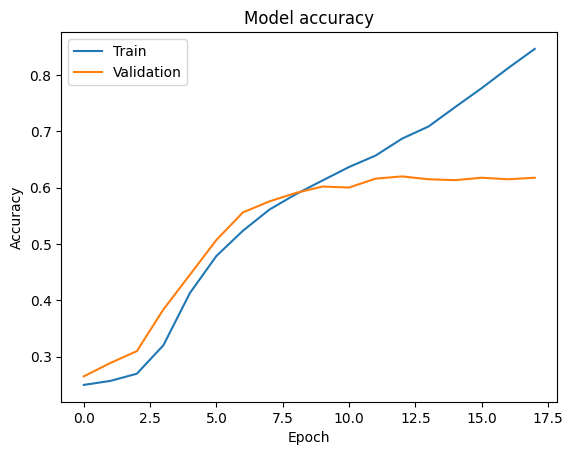

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

I0000 00:00:1711641685.133800   62335 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_366', 8 bytes spill stores, 8 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 


2024-03-28 12:01:26.789589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


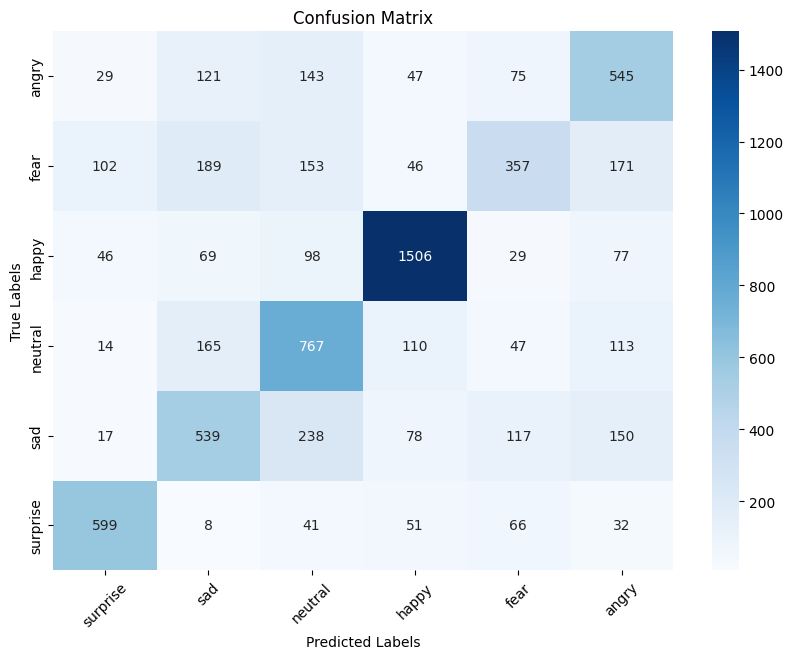

              precision    recall  f1-score   support

       angry       0.50      0.57      0.53       960
        fear       0.52      0.35      0.42      1018
       happy       0.82      0.83      0.82      1825
     neutral       0.53      0.63      0.58      1216
         sad       0.49      0.47      0.48      1139
    surprise       0.74      0.75      0.75       797

    accuracy                           0.62      6955
   macro avg       0.60      0.60      0.60      6955
weighted avg       0.62      0.62      0.62      6955



In [70]:
plot_accuracy(history)

y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels)
    y_pred.extend(model.predict(images))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

plot_confusion_matrix(y_true, y_pred, class_list)

print(classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=class_list))
